# Lucas-pricing of Markov trees

## A notebook by [Mateo Velásquez-Giraldo](https://mv77.github.io/)

This notebooks presents simple computational tools to solve Lucas' asset-pricing model when the asset's dividend process follows a Markov process of order one.

A presentation of this model can be found in [Christopher D. Carroll's lecture notes](http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/AssetPricing/LucasAssetPrice/).

\begin{equation*}
P_t(d_t) = E_{t}\left[ \frac{u(d_{t+1})}{u(d_t)} (P_{t+1}(d_{t+1}) + d_{t+1}) \right]
\end{equation*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from HARK.utilities import CRRAutilityP

In [2]:

class MarkovDstn:
    
    def __init__(self, Values, TransMat):
        
        self.Values = Values
        self.TransMat = TransMat

class LucasEconomy:
    
    def __init__(self, CRRA, DiscFac, DivDist):
        
        self.CRRA = CRRA
        self.DiscFac = DiscFac
        self.DivDist = DivDist
        self.uP = lambda c: CRRAutilityP(c, self.CRRA)
        
    def priceOnePeriod(self, price_next):
        
        # Create 'tiled arrays' rows are state today, columns are state
        # tomorrow.
        n_states = len(self.DivDist.Values)
        
        # Dividends now
        d_now = np.tile(np.reshape(self.DivDist.Values, (n_states,1)),
                        (1, n_states))
        # Dividends tomorrow
        d_next = np.tile(np.reshape(self.DivDist.Values, (1, n_states)),
                        (n_states,1))
        # Prices tomorrow
        p_next = np.tile(np.reshape(price_next, (1, n_states)),
                        (n_states,1))
        
        # Compute the RHS of the pricing equation, pre-expectation
        Mpd = self.uP(d_next)/self.uP(d_now) * (p_next + d_next)

        # Take expectation and discount
        P_now = self.DiscFac * np.sum(Mpd*self.DivDist.TransMat, axis = 1, keepdims=True)
        
        return(P_now)
        
    def solve(self, P_0= None, tol = 1e-5, disp = False):
        
        # Define an initial price vector if not given
        if P_0 is None:
            P_0 = np.ones((len(self.DivDist.Values),1))
        
        # Initialize the norm
        norm = tol + 1
        
        it = 0
        while norm > tol:
            
            # Apply the pricing equation
            P_next = self.priceOnePeriod(P_0)
            # Measure the change between price vectors
            norm = np.linalg.norm(P_0 - P_next)
            # Update price vector
            P_0 = P_next
            it = it + 1
            # Print iteration information
            if disp:
                print('Iter:' + str(it) + '   P = '+ np.array2string(np.transpose(P_0)))
        
        self.EqPrice = P_0

In [3]:

# Create a Markov process for dividends. A basic high-mid-low with 
# persistence
divs = np.array([0.5, 1, 1.5])
Trans = np.array([[0.5, 0.5, 0.0],
                  [0.2, 0.6, 0.2],
                  [0.0, 0.5, 0.5]])

DivDist = MarkovDstn(divs, Trans)


economy = LucasEconomy(CRRA = 2, DiscFac = 0.9, DivDist = DivDist)

# Some initial guess for the price function
p0 = np.array([[1],[2],[3]])
# 
print(economy.priceOnePeriod(p0))
economy.solve(disp = True)

[[1.0125]
 [3.06  ]
 [5.0625]]
Iter:1   P = [[0.9  2.36 3.15]]
Iter:2   P = [[1.008  3.1944 5.4945]]
Iter:3   P = [[1.15047  3.910296 7.394355]]
Iter:4   P = [[1.2951198  4.55144664 8.97413445]]
Iter:5   P = [[ 1.43234166  5.1281982  10.33420023]]
Iter:6   P = [[ 1.55897604  5.64724904 11.53019078]]
Iter:7   P = [[ 1.67435474  6.11439249 12.5939255 ]]
Iter:8   P = [[ 1.77882879  6.5348214  13.54558887]]
Iter:9   P = [[ 1.87314036  6.91320739 14.39952166]]
Iter:10   P = [[ 1.95814899  7.25375478 15.16690723]]
Iter:11   P = [[ 2.03471446  7.56024744 15.85703497]]
Iter:12   P = [[ 2.10364934  7.83609083 16.47791627]]
Iter:13   P = [[ 2.16570242  8.08434987 17.03660428]]
Iter:14   P = [[ 2.22155545  8.30778302 17.53937617]]
Iter:15   P = [[ 2.27182554  8.50887285 17.99184959]]
Iter:16   P = [[ 2.31706969  8.6898537  18.39906607]]
Iter:17   P = [[ 2.3577899   8.85273646 18.7655566 ]]
Iter:18   P = [[ 2.39443831  8.99933094 19.09539613]]
Iter:19   P = [[ 2.42742197  9.13126598 19.39225084]]


# Prices and risk-aversion

Text(0, 0.5, '$P_t$')

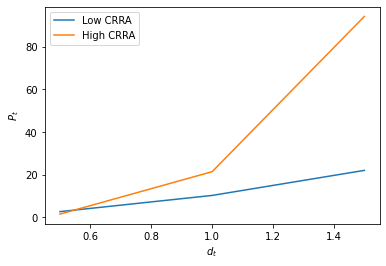

In [4]:
# Create two economies
Disc = 0.9
LowCrraEcon  = LucasEconomy(CRRA = 2, DiscFac = Disc, DivDist = DivDist)
HighCrraEcon = LucasEconomy(CRRA = 4, DiscFac = Disc, DivDist = DivDist)

# Solve both
LowCrraEcon.solve()
HighCrraEcon.solve()

# Plot the pricing functions for both
plt.plot(DivDist.Values, LowCrraEcon.EqPrice, label = 'Low CRRA')
plt.plot(DivDist.Values, HighCrraEcon.EqPrice, label = 'High CRRA')
plt.legend()
plt.xlabel('$d_t$')
plt.ylabel('$P_t$')